In [186]:
import sys
src_path = "../src/"
if src_path not in sys.path:
    sys.path.append(src_path)

from helpers_module import helpers as hlp


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, MissingIndicator

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_squared_log_error

pd.options.display.max_columns = None
pd.options.display.max_rows = 30
plt.style.use(style='ggplot')

## Load data

In [187]:
RANDOM_STATE=27

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

test_id_col = test_df['Id']
n_train = train_df.shape[0]
n_test = test_df.shape[0]

print(f"Train rows: {n_train}, Test rows: {n_test}")
train_df


Train rows: 1460, Test rows: 1459


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

## Common preprocessing

In [188]:
# drop train rows without target value
train_df.dropna(subset = ['SalePrice'], inplace=True)

# keep target column from train and keep it in variable
target = train_df['SalePrice']
train_df.drop(columns=['SalePrice'], inplace=True)

# Concat train and test to common prepearing 
union_df = pd.concat([train_df, test_df]).reset_index(drop=True)

## Prepearing data


### Hard drop columns

In [189]:
# hard list of columns to drop
columns_to_drop_hard = ['Id']
union_df = union_df.drop(columns_to_drop_hard, axis=1)


### Check missing values

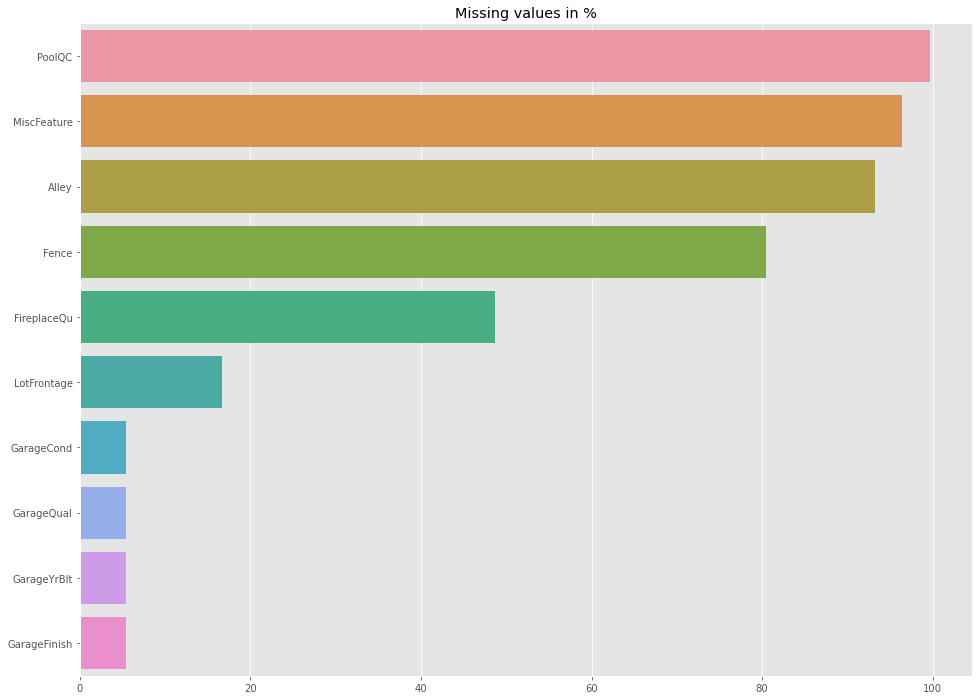

In [190]:
def print_missing_values(df):
    data = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
    data = data.head(10)

    plt.figure(figsize=(16,12))
    ax = sns.barplot(y=data.index, x=data.values)
    ax.set_title("Missing values in %")
    
print_missing_values(union_df)

### Check unique values in categorical

In [191]:
df = hlp.get_unique_values_by_columns(union_df) 
df.head(20)

,nunique,unique
Column,,
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
Exterior2nd,16,"[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ..."
Exterior1st,15,"[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ..."
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Condition1,9,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ..."
Condition2,8,"[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ..."
HouseStyle,8,"[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,..."
RoofMatl,8,"[CompShg, WdShngl, Metal, WdShake, Membran, Ta..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev, nan]"


### Fill categorical missing values

In [192]:
# fill 'None' in columns where NA mean None (e.g. no basement or garage)
for col in [
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu', 
        'GarageFinish', 'GarageType', 'GarageQual', 'GarageCond',
        'Alley', 'PoolQC', 'Fence', 'MiscFeature',
        'MasVnrType'
    ] :

    union_df[col].fillna('None', inplace=True)

    
# fill most frequent
for col in [
        'MSZoning', 'Functional', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 'Electrical'
    ]:
    
    union_df[col].fillna(union_df[col].mode()[0], inplace=True)


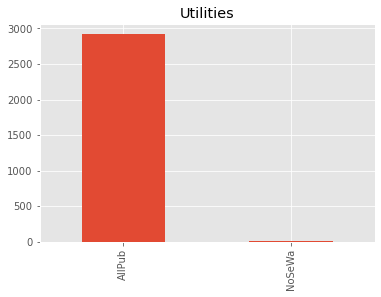

In [193]:
ax = union_df['Utilities'].value_counts().plot(kind='bar')
ax.set_title('Utilities')

# non-informative - just drop
union_df.drop(columns=['Utilities'], inplace=True)

### Fill numerical missing values

In [194]:
# fill median of Neighborhood (locations) in LotFrontage
union_df["LotFrontage"] = union_df\
                            .groupby("Neighborhood")["LotFrontage"]\
                            .transform(lambda x: x.fillna(x.median()))


for col in [
        'GarageYrBlt', 'GarageArea', 'GarageCars',
        'MasVnrArea',
        'BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2', 'BsmtFinSF1'
    ]:
    
    union_df[col].fillna(0, inplace=True)

    
numeric_cols = hlp.get_numeric_cols(union_df)

###  Check missing values again

In [195]:
print("Count of missing values: ", union_df.isna().sum().sum())

Count of missing values:  0


### Encoding categorical columns

In [196]:
cat=2

# 1. Just drop all categorial columns
if cat == 1:
    union_df = hlp.drop_str_cols(union_df)

# ------ OR ------

# 2. Encode by simple labels
if cat == 2:
    union_df = hlp.encode_with_labels(union_df)

# ------ OR ------

# 3. Encode by one hot
if cat == 3:
    union_df = hlp.encode_with_one_hot(union_df)


## Numerical columns processing

In [197]:
min_max_scaler = MinMaxScaler()

# union_df = min_max_scaler.fit_transform()


## Split data back

In [199]:
train_df = union_df[:n_train]
test_df = union_df[n_train:]

train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,1,3,3,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706.0,6,0.0,150.0,856.0,1,0,1,4,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4
1,20,3,80.0,9600,1,1,3,3,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1262.0,1,0,1,4,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4
2,60,3,68.0,11250,1,1,0,3,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,920.0,1,0,1,4,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4
3,70,3,60.0,9550,1,1,0,3,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216.0,6,0.0,540.0,756.0,1,2,1,4,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0
4,60,3,84.0,14260,1,1,0,3,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1145.0,1,0,1,4,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,4,0,8,2,2,0,5,6,5,1999,2000,1,1,12,13,2,0.0,3,4,2,2,4,3,6,0.0,6,0.0,953.0,953.0,1,0,1,4,953,694,0,1647,0.0,0.0,2,1,3,1,3,7,6,1,5,1,1999.0,2,2.0,460.0,5,5,2,0,40,0,0,0,0,3,4,1,0,8,2007,8,4
1456,20,3,85.0,13175,1,1,3,3,4,0,14,2,2,0,2,6,6,1978,1988,1,1,9,10,3,119.0,3,4,1,2,4,3,0,790.0,5,163.0,589.0,1542.0,1,4,1,4,2073,0,0,2073,1.0,0.0,2,0,3,1,3,7,2,2,5,1,1978.0,3,2.0,500.0,5,5,2,349,0,0,0,0,0,3,2,1,0,2,2010,8,4
1457,70,3,66.0,9042,1,1,3,3,4,0,6,2,2,0,5,7,9,1941,2006,1,1,5,5,2,0.0,0,2,4,4,1,3,2,275.0,6,0.0,877.0,1152.0,1,0,1,4,1188,1152,0,2340,0.0,0.0,2,0,4,1,2,9,6,2,2,1,1941.0,2,1.0,252.0,5,5,2,0,60,0,0,0,0,3,0,3,2500,5,2010,8,4
1458,20,3,68.0,9717,1,1,3,3,4,0,12,2,2,0,2,5,6,1950,1996,3,1,8,8,2,0.0,3,4,1,4,4,2,2,49.0,5,1029.0,0.0,1078.0,1,2,1,0,1078,0,0,1078,1.0,0.0,1,0,2,1,2,5,6,0,3,1,1950.0,3,1.0,240.0,5,5,2,366,0,112,0,0,0,3,4,1,0,4,2010,8,4



## Prepearing for model

In [200]:
X = train_df
y = np.log1p(target)

X_test = test_df

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_STATE)

## Research Model

In [ ]:
need_find_best_params=False

if need_find_best_params:
    xgb_params = {
        'colsample_bytree': 0.3, 
        'learning_rate': 0.05, 
        'max_depth': 3, 
        'min_child_weight': 1, 
        'reg_alpha': 0, 
        'reg_lambda': 2, 
        'subsample': 0.5
    }

    param_grid = {
        "n_estimators": [500,600,700,800,900,1000,1200,1500,1700,2000,2500,3000,4000,5000]
    }


    reserch_model = XGBRegressor(**xgb_params)

    xgb_rscv = GridSearchCV(reserch_model, param_grid = param_grid, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=4,
                                  cv=5,
                                  verbose = True)

#     model_xgboost = xgb_rscv.fit(X_train, y_train,early_stopping_rounds=200,
#               eval_set=[(X_valid, y_valid)], eval_metric='rmsle', verbose=False)

    model_xgboost = xgb_rscv.fit(X, y, eval_metric='rmse', verbose=False)

    best_params = model_xgboost.best_params_
    print(f"Best score: {model_xgboost.best_score_:.5f} \nBest params: {best_params}")


In [ ]:
# xgb_params = best_params

# xgb_params = {    
#     "learning_rate": 0.05,
#     "max_depth": 3,    
#     'reg_lambda': 1.5,
#     'n_estimators': 500
# }

xgb_params = {
    'colsample_bytree': 0.3, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 1, 
    'n_estimators': 700, 
    'reg_alpha': 0, 
    'reg_lambda': 2, 
    'subsample': 0.5
}

reserch_model = XGBRegressor(**xgb_params)

reserch_model.fit(X_train, y_train, early_stopping_rounds=200, 
          eval_set=[(X_valid, y_valid)], eval_metric='rmse', verbose=False)

y_train_pred = reserch_model.predict(X_train)
y_valid_pred = reserch_model.predict(X_valid)

print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y_train, y_train_pred))))
print("RMSE: {:.5f}".format(sqrt(mean_squared_error(y_valid, y_valid_pred))))
print("R2: {:.5f}".format(r2_score(y_valid, y_valid_pred)))
print("Best: {:.5f}, iter={:d}".format(reserch_model.best_score, reserch_model.best_iteration))



In [ ]:
xgb_params['n_estimators'] = reserch_model.best_iteration

# check by r2 score by cross validation
model_for_cross_val = XGBRegressor(**xgb_params)

rmse = cross_val_score(model_for_cross_val, X, y, scoring=('neg_mean_squared_error')).mean()
# rmsle = cross_val_score(model_for_cross_val, X, y, scoring=('neg_mean_squared_log_error')).mean()
r2 = cross_val_score(model_for_cross_val, X, y, scoring=('r2')).mean()

print("RMSE mean: {:.5f}".format(rmse))
# print("RMSLE mean: {:.5f}".format(rmsle))
print("R2 mean: {:.5f}".format(r2))

## Train model

In [ ]:
model_final = XGBRegressor(**xgb_params)
model_final.fit(X, y)

y_train_pred = model_final.predict(X)

print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y, y_train_pred))))
print("RMSLE train: {:.5f}".format(sqrt(mean_squared_log_error(y, y_train_pred))))
print("R2 train: {:.5f}".format(r2_score(y, y_train_pred)))

## Prediction and save result

In [ ]:
def params_to_str(params):
    res = ""
    for k,v in params.items():
        for s in k.split('_'):
            res += s[:2]
        res += str(v)
        res += "_"
        
    return res[:-1]


In [ ]:
y_test_pred = np.expm1(model_final.predict(X_test))

output = pd.DataFrame({'Id': test_id_col, 'SalePrice': y_test_pred})
output.to_csv(f'../data/rmse_{rmse:.5f}_xgb{reserch_model.best_iteration}_r_Id_enc-cat{cat}_logy_{params_to_str(xgb_params)}.csv', index=False)

In [201]:
need_find_best_params=False

if need_find_best_params:
    xgb_params = {
        'colsample_bytree': 0.3, 
        'learning_rate': 0.05, 
        'max_depth': 3, 
        'min_child_weight': 1, 
        'reg_alpha': 0, 
        'reg_lambda': 2, 
        'subsample': 0.5
    }

    param_grid = {
        "n_estimators": [500,600,700,800,900,1000,1200,1500,1700,2000,2500,3000,4000,5000]
    }


    reserch_model = XGBRegressor(**xgb_params)

    xgb_rscv = GridSearchCV(reserch_model, param_grid = param_grid, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=4,
                                  cv=5,
                                  verbose = True)

#     model_xgboost = xgb_rscv.fit(X_train, y_train,early_stopping_rounds=200,
#               eval_set=[(X_valid, y_valid)], eval_metric='rmsle', verbose=False)

    model_xgboost = xgb_rscv.fit(X, y, eval_metric='rmse', verbose=False)

    best_params = model_xgboost.best_params_
    print(f"Best score: {model_xgboost.best_score_:.5f} \nBest params: {best_params}")


In [202]:
# xgb_params = best_params

# xgb_params = {    
#     "learning_rate": 0.05,
#     "max_depth": 3,    
#     'reg_lambda': 1.5,
#     'n_estimators': 500
# }

xgb_params = {
    'colsample_bytree': 0.3, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 1, 
    'n_estimators': 700, 
    'reg_alpha': 0, 
    'reg_lambda': 2, 
    'subsample': 0.5
}

reserch_model = XGBRegressor(**xgb_params)

reserch_model.fit(X_train, y_train, early_stopping_rounds=200, 
          eval_set=[(X_valid, y_valid)], eval_metric='rmse', verbose=False)

y_train_pred = reserch_model.predict(X_train)
y_valid_pred = reserch_model.predict(X_valid)

print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y_train, y_train_pred))))
print("RMSE: {:.5f}".format(sqrt(mean_squared_error(y_valid, y_valid_pred))))
print("R2: {:.5f}".format(r2_score(y_valid, y_valid_pred)))
print("Best: {:.5f}, iter={:d}".format(reserch_model.best_score, reserch_model.best_iteration))



RMSE train: 0.05594
RMSE: 0.12582
R2: 0.89938
Best: 0.12582, iter=674


In [203]:
xgb_params['n_estimators'] = reserch_model.best_iteration

# check by r2 score by cross validation
model_for_cross_val = XGBRegressor(**xgb_params)

rmse = cross_val_score(model_for_cross_val, X, y, scoring=('neg_mean_squared_error')).mean()
# rmsle = cross_val_score(model_for_cross_val, X, y, scoring=('neg_mean_squared_log_error')).mean()
r2 = cross_val_score(model_for_cross_val, X, y, scoring=('r2')).mean()

print("RMSE mean: {:.5f}".format(rmse))
# print("RMSLE mean: {:.5f}".format(rmsle))
print("R2 mean: {:.5f}".format(r2))

RMSE mean: -0.01456
R2 mean: 0.90920


## Train model

In [204]:
model_final = XGBRegressor(**xgb_params)
model_final.fit(X, y)

y_train_pred = model_final.predict(X)

print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y, y_train_pred))))
print("RMSLE train: {:.5f}".format(sqrt(mean_squared_log_error(y, y_train_pred))))
print("R2 train: {:.5f}".format(r2_score(y, y_train_pred)))

RMSE train: 0.06264
RMSLE train: 0.00486
R2 train: 0.97539


## Prediction and save result

In [205]:
def params_to_str(params):
    res = ""
    for k,v in params.items():
        for s in k.split('_'):
            res += s[:2]
        res += str(v)
        res += "_"
        
    return res[:-1]


In [206]:
y_test_pred = np.expm1(model_final.predict(X_test))

output = pd.DataFrame({'Id': test_id_col, 'SalePrice': y_test_pred})
output.to_csv(f'../data/rmse_{rmse:.5f}_xgb{reserch_model.best_iteration}_r_Id_enc-cat{cat}_logy_{params_to_str(xgb_params)}.csv', index=False)